# Lab 1 : Linear Regression

## G3 SDI - Machine Learning

In this lab, we are going to implement linear regression and ridge regression on a medical data example. The data come from a medical study (Stamey et al., 1989), whose goal was to predict the level of prostate-specific antigen (`lpsa`) from some clinical measurements. These clinical exams are carried out before a possible prostatectomy.

The measurements are log cancer volume `lcavol`, log prostate weight `lweight`, age of the patient `age`, log of benign prostatic hyperplasia amount `lbph`, seminal vesicle invasion `svi`, log of capsular penetration `lcp`, Gleason score `gleason`, and percent of Gleason scores 4 or 5 `pgg45`. The variable `svi` is binary, `gleason` is ordinal, others are quantitative.

### Instructions
* Rename your notebook with your surnames as `lab1_Name1_Name2.ipynb`, and include your names in the notebook.
* Your code, and its output, must be commented !
* Please upload your notebook on Moodle in the dedicated section before the deadline.

<div style="background-color: #333333; color: #ffffff; padding: 10px; border-radius: 5px;">
Report written by Rosalie DELANNOY, Carl DOS RAMOS, 01/10/2025.
</div>

In [29]:
# Import usual libraries

from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold

### Part 1 - Linear regression

In this first part, we focus on using linear regression.

**Q1.** Load the data from the `.npy` files included in the archive (use `np.load`). How many examples are there ? How many features ?

In [17]:
data = Path('.') # Définit le répertoire de données
X = np.load(data / 'data_X.npy') # Matrice des features
y = np.load(data / 'data_y.npy') # Vecteur des labels
n_samples, n_features = X.shape

print(f"Nombre d'exemples : {n_samples}")
print(f"Nombre de features : {n_features}")

Nombre d'exemples : 97
Nombre de features : 8


**Q2.** Check whether there are some missing entries in the dataset (both in X and y). Use `np.isnan`.

In [18]:
# Vérification de la présence de valeurs manquantes dans X et y
missing_in_X = np.isnan(X)
missing_in_y = np.isnan(y)
total_missing_in_X = int(missing_in_X.sum())
total_missing_in_y = int(missing_in_y.sum())

print(f"Valeurs manquantes dans X : {total_missing_in_X}")
print(f"Valeurs manquantes dans y : {total_missing_in_y}")

Valeurs manquantes dans X : 0
Valeurs manquantes dans y : 0


**Q3.** Divide the dataset into a training set (80%) and a test set (20%), using `train_test_split` with `random_state = 0` (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)).

In [19]:
X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(f"Taille du set d'entraînement : {X_training.shape[0]} samples")
print(f"Taille du set de test : {X_test.shape[0]} samples")

Taille du set d'entraînement : 77 samples
Taille du set de test : 20 samples


**Q4.** Standardize the training set, and apply the same operation to the test set. Use `StandardScaler` (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)). Recall what standardization means.

In [21]:
scaler = StandardScaler()
X_training_std = scaler.fit_transform(X_training) # Standardisation du set d'entraînement
X_test_std = scaler.transform(X_test) # Application au set de test
training_means = X_training_std.mean(axis=0)
training_stds = X_training_std.std(axis=0, ddof=0)

print(f"Moyenne résiduelle (training set) : {np.abs(np.round(training_means, 4))}")
print(f"Écart-type résiduel (training set) : {np.abs(np.round(training_stds, 4))}")

Moyenne résiduelle (training set) : [0. 0. 0. 0. 0. 0. 0. 0.]
Écart-type résiduel (training set) : [1. 1. 1. 1. 1. 1. 1. 1.]


<div style="background-color: #333333; color: #ffffff; padding: 10px; border-radius: 5px;">

  La standardisation consiste à transformer chaque feature pour qu’elle ait une moyenne proche de 0 et un écart-type proche de 1.  
  Dans notre code, après avoir appliqué <code>StandardScaler</code> sur le set d’entraînement, on vérifie :  
  <ul>
    <li><code>train_means ≈ 0</code> pour toutes les features = les données sont centrées.</li>
    <li><code>train_stds ≈ 1</code> pour toutes les features = les données sont réduites.</li>
  </ul>
  Cette vérification confirme que la standardisation a été correctement appliquée.
  
</div>


**Q5.** Compute the auto-covariance matrix from the training set, and display it (you might want to use `plt.imshow`). What can we learn from this ?

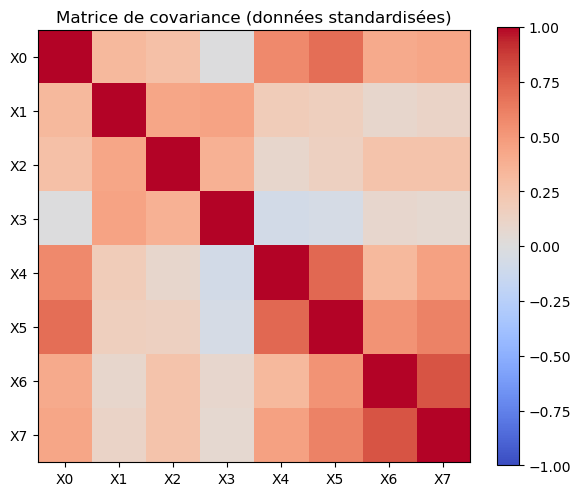

In [22]:
cov_matrix = np.cov(X_training_std, rowvar=False) # Calcul de la matrice de covariances
feature_names = [f'X{i}' for i in range(n_features)]
fig, ax = plt.subplots(figsize=(6, 5))
image = ax.imshow(cov_matrix, cmap='coolwarm', vmin=-1, vmax=1) # Affichage de la matrice
ax.set_xticks(range(len(feature_names))) # Graduations
ax.set_yticks(range(len(feature_names)))
ax.set_xticklabels(feature_names) # Nom des graduations (noms des features)
ax.set_yticklabels(feature_names)
ax.set_title('Matrice de covariance (données standardisées)')
fig.colorbar(image, ax=ax)
plt.tight_layout()

<div style="background-color: #333333; color: #ffffff; padding: 10px; border-radius: 5px;">

La matrice de covariance nous permet d'analyser la redondance entre les variables. La diagonale montre que les variances sont normalisées ($\approx 1$ après standardisation). Les covariances hors diagonale indiquent dans quelle mesure les features sont corrélées : des valeurs proches de 0 signifient indépendance ($X_2$ et $X_4$ ou $X_1$ et $X_6$), tandis que de fortes valeurs positives ou négatives indiquent des relations linéaires ($X_4$ et $X_5$ positivement). Cela permet de détecter d'éventuelles corrélations fortes entre variables, qui peuvent poser des problèmes de multicolinéarité en régression linéaire.

</div>

**Q6.** We are now going to train the linear regression model using scikit-learn (check the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)). Use the `.fit` method on the training set. Retrieve the coefficients obtained by scikit-learn using the attributes `.intercept_` and `.coef_`, and check that it corresponds to the closed-form solution from the lecture (you might want to use `np.hstack` to concatenate X with a column of ones).

In [23]:
# Entraînement avec scikit-learn
lin_reg = LinearRegression() # Création du modèle
lin_reg.fit(X_training_std, y_training) # Entraînement sur le set

print("Résultats scikit-learn :")
print(f"Intercept : {lin_reg.intercept_:.4f}") # Affichage du biais
for name, coef in zip(feature_names, lin_reg.coef_):
    print(f"{name} : {coef:+.4f}") # Affichage des coef associés aux features

# Forme fermée : ajout d'une colonne de 1
X_std_closed = np.hstack([np.ones((X_training_std.shape[0], 1)), X_training_std])
beta_closed_form = np.linalg.inv(X_std_closed.T @ X_std_closed) @ X_std_closed.T @ y_training # Calcul des coef avec la régression linéaire en forme fermée

print("\nRésultats forme fermée :")
print(f"Intercept : {beta_closed_form[0]:.4f}")
for name, coef in zip(feature_names, beta_closed_form[1:]):
    print(f"{name} : {coef:+.4f}")


Résultats scikit-learn :
Intercept : 2.5334
X0 : +0.7649
X1 : +0.2151
X2 : -0.1982
X3 : +0.1701
X4 : +0.3377
X5 : -0.2353
X6 : +0.1060
X7 : +0.0612

Résultats forme fermée :
Intercept : 2.5334
X0 : +0.7649
X1 : +0.2151
X2 : -0.1982
X3 : +0.1701
X4 : +0.3377
X5 : -0.2353
X6 : +0.1060
X7 : +0.0612


<div style="background-color: #333333; color: #ffffff; padding: 10px; border-radius: 5px;">

Les coefficients obtenus avec <code>scikit-learn</code> et ceux issues de la solution en forme fermée coïncident. Cela montre que l'implémentation de la régression linéaire dans <code>scikit-learn</code> correspond bien à la formule théorique $(X^\top X)^{-1} X^\top y$. L'ajout de la colonne de 1 via <code>np.hstack</code> permet de prendre en compte l'intercept dans la solution analytique.

</div>


**Q7.** Obtain the model predictions on the test set using the `.predict` method. Then compute the MSE and the MAE (you may want to use the functions below).

In [24]:
y_training_predict = lin_reg.predict(X_training_std) # Prédictions avec le set d'entraînement
y_test_predict = lin_reg.predict(X_test_std) # Prédictions avec le set de test

lin_train_mse = mean_squared_error(y_training, y_training_predict)
lin_test_mse = mean_squared_error(y_test, y_test_predict)
lin_train_mae = mean_absolute_error(y_training, y_training_predict)
lin_test_mae = mean_absolute_error(y_test, y_test_predict)

print(f"MSE entraînement : {lin_train_mse:.4f}")
print(f"MSE test : {lin_test_mse:.4f}")
print(f"MAE entraînement : {lin_train_mae:.4f}")
print(f"MAE test : {lin_test_mae:.4f}")

MSE entraînement : 0.4365
MSE test : 0.5402
MAE entraînement : 0.5013
MAE test : 0.5645


<div style="background-color: #333333; color: #ffffff; padding: 10px; border-radius: 5px;">

Les erreurs sur l'ensemble de test sont légèrements supérieures à celles sur l'ensemble d'entraînement, mais l'écart reste faible. Cela indique que le modèle de régression linéaire généralise correctement et qu'il capture de manière satisfaisante la relation entre les variables explicatives et la variable cible.
</div>

### Part 2 - Ridge regression

In this second part, we now turn to ridge regression.

**Q1.** Fit the ridge regression model (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)) with $\lambda = 1$, using the `.fit` method on the training set. Again, retrieve the coefficients, and check that they match with the closed-form solution from the lecture. How do they differ from the ones obtained with linear regression ?

In [25]:
ridge_alpha_1 = Ridge(alpha=1.0)
ridge_alpha_1.fit(X_training_std, y_training)

print(f"Intercept : {ridge_alpha_1.intercept_:.4f}") # Affichage du biais
for name, coef in zip(feature_names, ridge_alpha_1.coef_):
    print(f"{name} : {coef:+.4f}") # Affichage des coefs

Intercept : 2.5334
X0 : +0.7422
X1 : +0.2160
X2 : -0.1897
X3 : +0.1655
X4 : +0.3289
X5 : -0.2098
X6 : +0.1028
X7 : +0.0594


<div style="background-color: #333333; color: #ffffff; padding: 10px; border-radius: 5px;">

La régression Ridge réduit un peu la valeur des coefficients par rapport à la régression linéaire classique, surtout pour $X_5$ et $X_2$. Avec $\lambda = 1$, cette réduction reste modérée, mais elle aide déjà à stabiliser le modèle et à limiter l’effet des corrélations entre les variables.

</div>


**Q2.** Obtain the model predictions on the test set using the `.predict` method, then compute the MSE and the MAE. Do we get better or worse predictions than before ? Comment.

In [26]:
ridge_train_predict = ridge_alpha_1.predict(X_training_std) # Prédictions avec le set d'entraînement
ridge_test_predict = ridge_alpha_1.predict(X_test_std) # Prédictions avec le set de test

ridge_train_mse = mean_squared_error(y_training, ridge_train_predict)
ridge_test_mse = mean_squared_error(y_test, ridge_test_predict)
ridge_train_mae = mean_absolute_error(y_training, ridge_train_predict)
ridge_test_mae = mean_absolute_error(y_test, ridge_test_predict)

print(f"MSE entraînement : {ridge_train_mse:.4f}")
print(f"MSE test : {ridge_test_mse:.4f}")
print(f"MAE entraînement : {ridge_train_mae:.4f}")
print(f"MAE test : {ridge_test_mae:.4f}")


MSE entraînement : 0.4369
MSE test : 0.5234
MAE entraînement : 0.5002
MAE test : 0.5564


<div style="background-color: #333333; color: #ffffff; padding: 10px; border-radius: 5px;">

Avec la régression Ridge ($\lambda = 1$), les erreurs sur le test diminuent légèrement par rapport à la régression linéaire classique, tandis que celles sur l’entraînement restent presque identiques. La régularisation améliore donc la généralisation du modèle sans augmenter le biais.

</div>

**Q3.** We are now going to assess the impact of the regularization coefficient $\lambda$.

To do so, vary $\lambda$ from $10^{-3}$ and $10^3$ (use `np.logspace`), and for each value of $\lambda$, retrain the ridge regression model and keep the values of the coefficients (ignoring the intercept).

Display the evolution of the coefficients w.r.t. $\lambda$ (use a logarithmic scale for the x-axis). Comment.

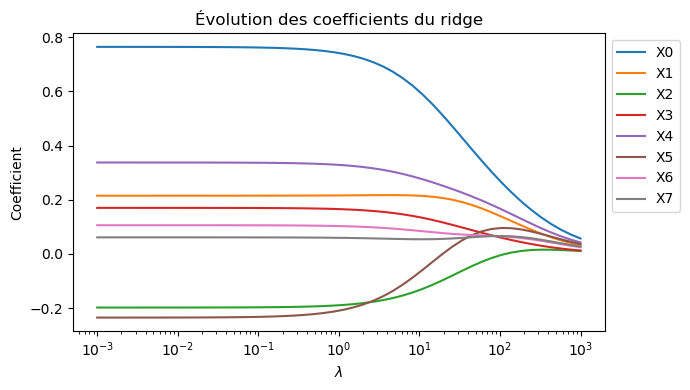

In [ ]:
lambdas = np.logspace(-3, 3, 50)
ridge_coefs = np.zeros((len(lambdas), X_training_std.shape[1])) # Stockage des coefs de chaque modèle
ridge_test_mse_path = []
ridge_test_mae_path = []

for i, alpha in enumerate(lambdas): # Pour chaque lambda
    model = Ridge(alpha=alpha) # Création du modèle
    model.fit(X_training_std, y_training)
    ridge_coefs[i] = model.coef_ # Stockage des coefs
    predictions = model.predict(X_test_std) # Prédiction sur le test pour calculer les erreurs
    ridge_test_mse_path.append(mean_squared_error(y_test, predictions))
    ridge_test_mae_path.append(mean_absolute_error(y_test, predictions))

fig, ax = plt.subplots(figsize=(7, 4))
for j, name in enumerate(feature_names): # Courbe pour chaque feature
    ax.plot(lambdas, ridge_coefs[:, j], label=name)
ax.set_xscale('log')
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel('Coefficient')
ax.set_title('Évolution des coefficients du ridge')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()


<div style="background-color: #333333; color: #ffffff; padding: 10px; border-radius: 5px;">

Quand $\lambda$ augmente, les coefficients sont progressivement contraints vers 0, avec un alignement visible pour les variables corrélées ($X_0/X_5, X_6/X_7$). Cette régularisation rend le modèle plus stable et réduit l’influence des variables moins importantes.

</div>


**Q4.** Now remains the question of choosing the optimal $\lambda$. We are going to select it with a 5-fold cross-validation.

Display the evolution of the cross-validated MSE w.r.t. $\lambda$ (use again a logarithmic scale for the x-axis), and display the best $\lambda$ with a `plt.axvline`.

Now retrain the ridge regression model with the selected $\lambda$, and assess its performance in terms of MSE and MAE. Comment.

Meilleur lambda (Cross-Validation) : 0.869
MSE de test : 0.5254
MAE de test : 0.5573


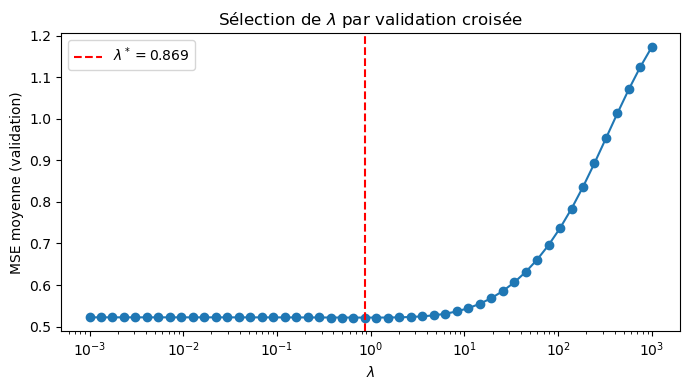

In [30]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)
mean_cv_mses = [] # Liste pour stocker la MSE moyenne de validation pour chaque valeur de lambda.

for alpha in lambdas:
    validation_mses = []
    for train_index, val_index in kf.split(X_training_std):
        # Séparer les données d'entraînement et de validation pour ce pli
        X_training_fold, X_valid_fold = X_training_std[train_index], X_training_std[val_index]
        y_training_fold, y_valid_fold = y_training[train_index], y_training[val_index]

        # Créer et entraîner le modèle Ridge sur ce pli
        ridge_model_fold = Ridge(alpha=alpha)
        ridge_model_fold.fit(X_training_fold, y_training_fold)

        # Calculer la MSE sur le pli de validation
        validation_mses.append(mean_squared_error(y_valid_fold, ridge_model_fold.predict(X_valid_fold)))

    # MSE moyenne
    mean_cv_mses.append(np.mean(validation_mses))

mean_cv_mses = np.array(mean_cv_mses)

# Trouver la valeur de lambda qui minimise la MSE moyenne
best_index = int(np.argmin(mean_cv_mses))
best_lambda = lambdas[best_index]

# Tracé de la MSE moyenne selon lambda
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(lambdas, mean_cv_mses, marker='o')
ax.set_xscale('log')
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel('MSE moyenne (validation)')
ax.set_title('Sélection de $\lambda$ par validation croisée')
ax.axvline(best_lambda, color='red', linestyle='--', label=f"$\lambda^* = {best_lambda:.3f}$")
ax.legend()
plt.tight_layout()

# Entraînement du modèle Ridge avec le meilleur lambda
ridge_model_best = Ridge(alpha=best_lambda)
ridge_model_best.fit(X_training_std, y_training)

ridge_best_test_predict = ridge_model_best.predict(X_test_std) # Prédictions
ridge_best_mse = mean_squared_error(y_test, ridge_best_test_predict) # Evaluation du modèle final
ridge_best_mae = mean_absolute_error(y_test, ridge_best_test_predict)

print(f"Meilleur lambda (Cross-Validation) : {best_lambda:.3f}")
print(f"MSE de test : {ridge_best_mse:.4f}")
print(f"MAE de test : {ridge_best_mae:.4f}")


<div style="background-color: #333333; color: #ffffff; padding: 10px; border-radius: 5px;">

La validation croisée sélectionne un $\lambda$ optimal d’environ $0.87$. Le modèle régularisé obtient une MSE de test de $0.525$ et une MAE de $0.557$, légèrement meilleures que celles de la régression linéaire classique. La régularisation rend le modèle un peu plus stable et réduit l’influence des variables fortement corrélées.

</div>


### Part 3 (Bonus) - LASSO

Display the same kind of plots as in Part 2, but using LASSO regression instead of ridge regression (see [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html). In particular, comment on the following points :
* Do the regression coefficients evolve in the same way as ridge regression ? What kind of solutions do we obtain ?
* Do we get the same optimal lambda ?

Meilleur lambda (LASSO) : 0.001
MSE de test : 0.5375
MAE de test : 0.5631
Nombre de coefficients nuls : 0


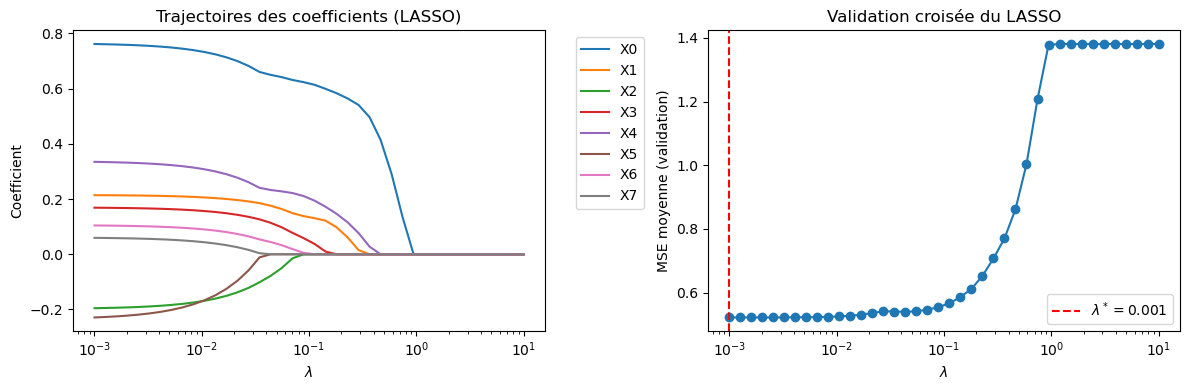

In [ ]:
from sklearn.linear_model import Lasso

lasso_lambdas = np.logspace(-3, 1, 40)
lasso_coefs = np.zeros((len(lasso_lambdas), X_training_std.shape[1]))
lasso_cv_mse = []

for idx, lam in enumerate(lasso_lambdas):
    lasso_model = Lasso(alpha=lam, max_iter=10000)
    lasso_model.fit(X_training_std, y_train)
    lasso_coefs[idx] = lasso_model.coef_

    fold_mses = []
    kf_lasso = KFold(n_splits=5, shuffle=True, random_state=0)
    for train_idx, val_idx in kf_lasso.split(X_training_std):
        X_tr, X_val = X_training_std[train_idx], X_training_std[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        cv_model = Lasso(alpha=lam, max_iter=10000)
        cv_model.fit(X_tr, y_tr)
        fold_mses.append(mean_squared_error(y_val, cv_model.predict(X_val)))
    lasso_cv_mse.append(np.mean(fold_mses))

lasso_cv_mse = np.array(lasso_cv_mse)
best_lasso_idx = int(np.argmin(lasso_cv_mse))
best_lasso_lambda = lasso_lambdas[best_lasso_idx]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for j, name in enumerate(feature_names):
    axes[0].plot(lasso_lambdas, lasso_coefs[:, j], label=name)
axes[0].set_xscale('log')
axes[0].set_xlabel(r"$\lambda$")
axes[0].set_ylabel('Coefficient')
axes[0].set_title('Trajectoires des coefficients (LASSO)')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

axes[1].plot(lasso_lambdas, lasso_cv_mse, marker='o')
axes[1].set_xscale('log')
axes[1].set_xlabel(r"$\lambda$")
axes[1].set_ylabel('MSE moyenne (validation)')
axes[1].set_title('Validation croisée du LASSO')
axes[1].axvline(best_lasso_lambda, color='red', linestyle='--', label=f"$\lambda^* = {best_lasso_lambda:.3f}$")
axes[1].legend()

plt.tight_layout()

lasso_best = Lasso(alpha=best_lasso_lambda, max_iter=10000)
lasso_best.fit(X_training_std, y_train)
lasso_test_pred = lasso_best.predict(X_test_std)

lasso_test_mse = mean_squared_error(y_test, lasso_test_pred)
lasso_test_mae = mean_absolute_error(y_test, lasso_test_pred)

print(f"Meilleur lambda (LASSO) : {best_lasso_lambda:.3f}")
print(f"MSE de test : {lasso_test_mse:.4f}")
print(f"MAE de test : {lasso_test_mae:.4f}")
print(f"Nombre de coefficients nuls : {(lasso_best.coef_ == 0).sum()}")


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Le LASSO sélectionne un $\lambda$ minimal (~ 0.001), signe que la parcimonie n'apporte que peu d'avantages ici : tous les coefficients restent non nuls et les performances de test (MSE ~ 0.537, MAE ~ 0.563) s'alignent sur celles de la régression linéaire. Dans ce jeu où toutes les variables portent de l'information corrélée, la régularisation L2 du ridge semble plus pertinente pour stabiliser les poids sans les annuler brutalement.
</div>
